<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [18]:
""" Import Statements """

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from bs4 import BeautifulSoup
from sklearn.neighbors import NearestNeighbors
# Beautiful Soup assists in cleaning the job listings

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [19]:
job_listings = ('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module2-vector-representations/data/job_listings.csv')
jobs = pd.read_csv(job_listings)
text = jobs['description']

In [20]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
"""
Getting individual text from description column from soup documentation
soup = BeautifulSoup(text[0])
print(soup.prettify())
soup.get_text()
"""

job_description = []

for doc in text:
    soup = BeautifulSoup(doc)
    soup_text = soup.get_text(" ")
    text = soup_text.replace("\\n", '')
    text2 = text.replace("/", " ")
    text3 = text2.replace('\\xe2\\x80\\x99', "'")
    text4 = text3.replace('\xe2\x80\x99', "'")
    text5 = text4.replace(' \xe2\x80\xa6', '')
    text6 = text5.replace('b"', '')
    text7 = text6.replace(' \xe2\x80\x93', '')
    text8 = text7.replace('nfosys\xe2\x80\x93', '')
    text9 = text8.replace("b'", '')
    job_description.append(text9)

print(*job_description[:3], sep= "\n\n")

jobs['text'] = job_description

jobs.head()


 Job Requirements: Conceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear  Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them  Intermediate to expert level coding skills in Python R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)  Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R  Ability to communicate Model findings to both Technical and Non-Technical stake holders  Hands on experience in SQL Hive or similar programming language  Must show past work via GitHub, Kaggle or any other published article  Master's degree in Statistics Mathematics Computer Science or any other quant specific field. Apply Now "

 Job Description   As a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their hea

,Unnamed: 0,description,title,text
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on co...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a month Contract Under the ge..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations...


In [21]:
# drop unused columns from jobs dataframe
jobs = jobs.drop(columns=["Unnamed: 0", 'description'])
jobs.head()

,title,text
0,Data scientist,Job Requirements: Conceptual understanding in...
1,Data Scientist I,"Job Description As a Data Scientist 1, you ..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on co...
3,Data Scientist,"$4,969 - $6,756 a month Contract Under the ge..."
4,Data Scientist,Location: USA \xe2\x80\x93 multiple locations...


In [22]:
# defining stop words - removing unuseful words from the text
nlp = spacy.load("en_core_web_lg")
STOP_WORDS = nlp.Defaults.stop_words.union(['\\n', 'b', 'etc', ' ', 'job','requirement', 'requirements', 'for\\xe2\\x80\\xa6','life\\xe2\\x80\\xa6',"we\\'re", "aren\\'t",'', 'b"'])

## 2) Use Spacy to tokenize the listings 

In [23]:
##### Your Code Here #####
importantwords = jobs['text'][1]
print([token.lemma_ for token in nlp(importantwords) if
       (token.is_punct == False) and
       (token.text.lower() not in STOP_WORDS)]) 

['description', '  ', 'Data', 'scientist', '1', 'help', 'build', 'machine', 'learning', 'model', 'data', 'pipeline', 'micro', 'service', 'help', 'client', 'navigate', 'healthcare', 'journey', 'empower', 'improve', 'generation', 'Accolade', 'Applications', 'user', 'experience', 'day', 'work', 'small', 'agile', 'team', 'design', 'develop', 'mobile', 'application', 'iterative', 'fashion', 'work', 'tight', 'knit', 'group', 'development', 'team', 'member', 'Seattle', 'contribute', 'good', 'practice', 'help', 'guide', 'future', 'application', 'operate', 'effectively', 'collaborative', 'member', 'development', 'team', 'operate', 'effectively', 'individual', 'quick', 'turnaround', 'enhancement', 'fix', 'responsible', 'meet', 'expectation', 'deliverable', 'time', 'high', 'quality', 'drive', 'implement', 'new', 'feature', 'mobile', 'application', 'perform', 'thorough', 'manual', 'testing', 'writing', 'test', 'case', 'cover', 'area', 'identify', 'new', 'development', 'tool', 'approach', 'increase

In [24]:
#tokenize
token = []
for doc in jobs['text']:
    text = [token.lemma_ for token in nlp(doc) if
            (token.is_punct == False) and
            (token.text.lower() not in STOP_WORDS)]
    token.append(text)
jobs['token'] = token
jobs.head(10)

,title,text,token
0,Data scientist,Job Requirements: Conceptual understanding in...,"[conceptual, understanding, Machine, Learning,..."
1,Data Scientist I,"Job Description As a Data Scientist 1, you ...","[description, , Data, scientist, 1, help, bu..."
2,Data Scientist - Entry Level,As a Data Scientist you will be working on co...,"[Data, scientist, work, consult, business, res..."
3,Data Scientist,"$4,969 - $6,756 a month Contract Under the ge...","[$, 4,969, $, 6,756, month, contract, general,..."
4,Data Scientist,Location: USA \xe2\x80\x93 multiple locations...,"[location, USA, \xe2\x80\x93, multiple, locati..."
5,Data Scientist,Create various Business Intelligence Analytic...,"[create, Business, Intelligence, Analytical, r..."
6,Associate Data Scientist – Premium Analytics,As Spotify Premium swells to over 96M subscri...,"[Spotify, Premium, swell, 96, M, subscriber, g..."
7,Data Scientist,"Everytown for Gun Safety, the nation's largest...","[Everytown, Gun, Safety, nation, large, gun, v..."
8,Sr. Data Scientist,MS in a quantitative discipline such as Stati...,"[MS, quantitative, discipline, Statistics, Mat..."
9,"Data Scientist, Lifecyle",Slack is hiring experienced data scientists t...,"[Slack, hire, experienced, datum, scientist, j..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [25]:
##### Your Code Here #####

# jobs text variable
wc = jobs['text']
#transformer function
vect = CountVectorizer()
#fit the vocab
vect.fit(wc)
#transform the text
dtm = vect.transform(wc)
print(dtm.shape)


(426, 8525)


In [26]:
dtm

<426x8525 sparse matrix of type '<class 'numpy.int64'>'
	with 111670 stored elements in Compressed Sparse Row format>

## 4) Visualize the most common word counts

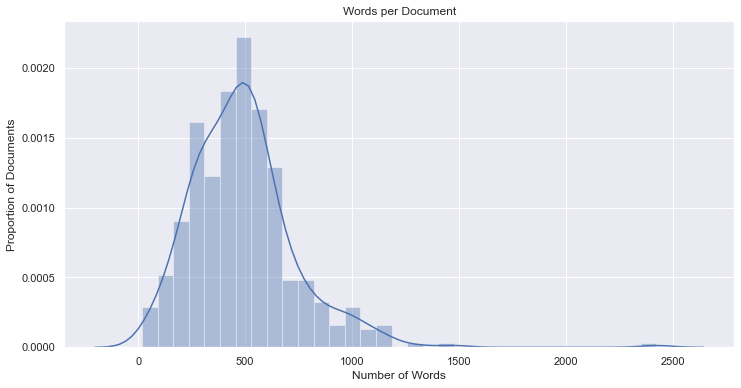

In [27]:
##### Your Code Here #####
import seaborn as sns
sns.set()
num_words = [len(s.split()) for s in jobs['text']]
plt.figure(figsize=(12, 6))
sns.distplot(num_words)
plt.title('Words per Document')
plt.xlabel('Number of Words')
plt.ylabel('Proportion of Documents')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [28]:
##### Your Code Here #####
tfidf = TfidfVectorizer(stop_words = 'english',
                        ngram_range = (1, 2),
                        min_df = 3,
                        max_df = 0.01)
#The following should create the vocab and tf-idf score per document.
dtm = tfidf.fit_transform(jobs['text'])
#The following will get feature names to use as a df column headers.
dtm = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
print(dtm.shape)
dtm.head()

(426, 6205)


,04,10 time,100 premium,1079302,1079302 kbrwyle,11 04,14,150,19 2019,20 pounds,...,xef x83,xgboost,year simple,years analytical,years applied,years come,years requirements,years technical,york offices,yrs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [29]:
##### Your Code Here #####
# Fitting into dtm
NN = NearestNeighbors(n_neighbors=10, algorithm='kd_tree', leaf_size=50, n_jobs=6, p=10)
NN.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=50, metric='minkowski',
                 metric_params=None, n_jobs=6, n_neighbors=10, p=10,
                 radius=1.0)

In [30]:
NN.kneighbors([dtm.iloc[1].values])

(array([[0.        , 0.29682721, 0.29682721, 0.29682721, 0.29687564,
         0.29687824, 0.29687824, 0.29695633, 0.29700496, 0.29702777]]),
 array([[  1, 275, 240, 334,  89,  52, 142, 129, 238, 298]], dtype=int64))

In [31]:
jobs['text'][298][:8000]

'The Data Scientist will perform analysis and modeling for all demand generation and conversion elements including product, placement, price, and promotion in support of the short and long-term goals of the Sales & Marketing and Supply Chain teams.  Job responsibilities include but are not limited to: Perform data mining and predictive analytics to help answer questions to identify key areas within the various function for performance improvement and predict future outcomes and trends. Design, deploy and provide ongoing evaluations of the statistical models and data mining techniques for predictive learning applications. Establish scalable, efficient, automated processes for large-scale data analyses, model development, model validation, and model implementation. Discover patterns and anomalies in data using ad-hoc query visual discovery. Based on findings, make recommendations to management on possible actions to ensure the desired outcome. Collaborate with internal teams to generate 

In [32]:
Linkedin_job_posting = ["""
We’re looking for Data Scientists to work on our core and business products (ex. Instagram, Messenger, FB App, Ads, What's App, Integrity, etc.) to help shape the future of what we build at Facebook. You will enjoy working with one of the richest data sets in the world, cutting edge technology, and the ability to see your insights turned into real products on a regular basis. You should have a background in a quantitative or technical field, experience working with large data sets, and experience in data-driven decision making. You are focused on results, a self-starter, and have demonstrated success in using analytics to drive the understanding, growth, and success of a product.
Apply your expertise in quantitative analysis, data mining, and the presentation of data to see beyond the numbers and understand how our users interact with both our consumer and business products
Partner with Product and Engineering teams to solve problems and identify trends and opportunities
Inform, influence, support, and execute our product decisions and product launches
The Data Scientist Analytics role has work across the following four areas:
Product Operations
Forecasting and setting product team goals
Designing and evaluating experiments
Monitoring key product metrics, understanding root causes of changes in metrics
Building and analyzing dashboards and reports
Building key data sets to empower operational and exploratory analysis
Evaluating and defining metrics
Exploratory Analysis
Proposing what to build in the next roadmap
Understanding ecosystems, user behaviors, and long-term trends
Identifying new levers to help move key metrics
Building models of user behaviors for analysis or to power production systems
Product Leadership
Influencing product teams through presentation of data-based recommendations
Communicating state of business, experiment results, etc. to product teams
Spreading best practices to analytics and product teams
Data Infrastructure
Working in Hadoop and Hive primarily, sometimes MySQL, Oracle, and Vertica
Automating analyses and authoring pipelines via SQL and Python based ETL framework
Bachelors/Masters/PhD
4+ years of experience doing complex quantitative analysis and working with distributed (i.e. Hive, Hadoop or similar databases) or highly complex datasets
4+ years of experience with data querying languages (e.g. SQL), scripting languages (e.g. Python), or statistical/mathematical software (e.g. R, SAS, Matlab)
4+ years of experience with applied statistics or experimentation (i.e. A/B testing) in an industry setting
2+ years of experience communicating the results of analyses to leadership teams to influence the strategy
Experience in a consumer technology company
6+ years of experience in all the above minimums
Facebook is proud to be an Equal Opportunity and Affirmative Action employer. We do not discriminate based upon race, religion, color, national origin, sex (including pregnancy, childbirth, or related medical conditions), sexual orientation, gender, gender identity, gender expression, transgender status, sexual stereotypes, age, status as a protected veteran, status as an individual with a disability, or other applicable legally protected characteristics. We also consider qualified applicants with criminal histories, consistent with applicable federal, state and local law.

Facebook is committed to providing reasonable accommodations for candidates with disabilities in our recruiting process. If you need any assistance or accommodations due to a disability, please let us know at accommodations-ext@fb.com.
"""]

In [33]:
#The Query
Query = tfidf.transform(Linkedin_job_posting)
Query

<1x6205 sparse matrix of type '<class 'numpy.float64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [34]:
NN.kneighbors(Query.todense())

(array([[0.19918448, 0.27070866, 0.27070866, 0.27070866, 0.27079843,
         0.27079843, 0.2708195 , 0.27101705, 0.27111423, 0.27116605]]),
 array([[301, 275, 334, 240,  52, 142,  89, 129, 238, 298]], dtype=int64))

In [35]:
jobs['text'][100]

' Description  A rare opportunity to join the development division within Information Systems at Steward Health Care, the top leader in the competitive for-profit hospital industry. We are seeking a motivated and experienced Data Scientist to contribute to the software development initiatives that improve the quality of health care across the country. This individual will be working with programmers, analysts and senior level management to optimize the development process within the enterprise by expanding our existing predictive analytics field. Key Responsibilities  Conduct research and build actionable visualizations that drive decisions.  Collect data required to extract actionable insights.  Work with the subject matter experts and key stakeholders to understand end goals for enhancements and new predictive tools.  Values critical thinking and has the ability to solve complex problems with incomplete data and a genuine curiosity. Contribute to the team\'s overall knowledge by educ

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 